<a href="https://colab.research.google.com/github/rkspatel08/General_Notes/blob/main/PSL_Coding_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as lm
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [21]:
url = "https://raw.githubusercontent.com/liangfgithub/liangfgithub.github.io/master/Data/Coding2_Data1.csv"
myData = pd.read_csv(url)
# myData.head()
Y = myData['Y']
X = myData.drop(['Y'], axis = 1)

In [22]:
X.shape, len(Y)

((506, 91), 506)

**Conduct the following simulation exercise 50 times:**


a. In each iteration, randomly split the data into two parts, 75% for training and 25% for testing.

b. For each of the six procedures, train a model using the training subset and generate predictions for the test subset. Record the MSPE (Mean Squared Prediction Error) based on these test data predictions.

In [23]:
# randomly split the data into two parts, 75% for training and 25% for testing.
def split_train_test(X, Y):
  # Splitting the data into training and testing sets
  n = len(Y)
  indices = np.arange(0, n)
  np.random.shuffle(indices)
  test_ind = indices[:int(np.floor(0.25*n))]
  train_ind = indices[len(test_ind):]

  # Splitting the data into training and testing sets
  X_train1 = X.iloc[train_ind]
  Y_train = Y[train_ind]
  X_test1 = X.iloc[test_ind]
  Y_test = Y[test_ind]
  scaler = StandardScaler(with_mean=True, with_std=True)
  X_train = scaler.fit_transform(X_train1)
  X_test = scaler.transform(X_test1)
  return X_train, Y_train, X_test, Y_test

In [24]:
split_train_test(X, Y)

(array([[ 1.59436738, -0.50021994,  0.91977454, ..., -0.33765528,
          1.03167588, -0.90793536],
        [-0.54511164, -0.50021994,  0.24492938, ..., -0.1574539 ,
         -0.4037521 ,  0.2911495 ],
        [ 1.09012226, -0.50021994,  0.91977454, ...,  0.11925644,
          0.82221119, -0.35275361],
        ...,
        [-0.79727449,  1.35949545, -1.17077861, ..., -1.09679897,
         -1.13957743, -0.39089093],
        [-0.6745206 ,  0.73959032, -0.7176927 , ..., -0.88595644,
         -0.90440074,  0.15033615],
        [ 1.73484966, -0.50021994,  0.91977454, ...,  0.97243535,
          0.61762763,  0.63498998]]),
 409    3.314186
 205    3.117950
 460    2.797281
 402    2.493205
 386    2.351375
          ...   
 465    2.990720
 61     2.772589
 187    3.465736
 242    3.100092
 375    2.708050
 Name: Y, Length: 380, dtype: float64,
 array([[ 0.98771487, -0.50021994,  0.91977454, ...,  0.93895137,
          0.60530309,  0.56578273],
        [-1.31602363,  1.77276553, -1.0521113

**PCR Implemenation (as given in sample code)**

In [27]:
class PCR(object):

    def __init__(self, num_folds=10):
        self.folds = num_folds

    def fit(self, X, Y):
        n, p = X.shape
        indices = np.arange(n)
        np.random.shuffle(indices)
        index_sets = np.array_split(indices, self.folds)
        ncomp = min(p, n - 1 - max([len(i) for i in index_sets]))
        cv_err = np.zeros(ncomp)

        for ifold in range(self.folds):
            train_inds =  np.delete(index_sets, obj=ifold, axis=0).ravel()
            test_inds = index_sets[ifold]

            X_train = X[train_inds, :]
            pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA())])
            pipeline.fit(X_train)
            X_train = pipeline.transform(X_train)
            coefs = Y[train_inds].T @ X_train / np.sum(X_train**2, axis=0)
            b0 = np.mean(Y[train_inds])

            X_test = pipeline.transform(X[test_inds, :])

            for k in np.arange(ncomp):
                preds = X_test[:, :k] @ coefs.T[:k] + b0
                cv_err[k] += cv_err[k] + np.sum((Y[test_inds]-preds)**2)

        min_ind = np.argmin(cv_err)
        self.ncomp = min_ind+1
        pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=self.ncomp))])
        self.transform = pipeline.fit(X)
        self.model = lm().fit(self.transform.transform(X), Y)

    def predict(self, X):
        X_ = self.transform.transform(X)
        return self.model.predict(X_)

Run simulations,split the train and test data and train below models:

**Full**: Fit a linear regression model using all features

**Ridge.min** : Ridge regression using lambda.min

**Lasso.min and Lasso.1se:** Lasso using lambda.min or lambda.1se

**L.Refit:** Refit the model selected by Lasso using lambda.1se

**PCR**: principle components regression with the number of components chosen by 10-fold cross validation

In [28]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [29]:
# run simulation 50 times and train given models
sims = 50
full_mse_list, ridge_mse_list, lasso_min_list,lasso_1se_list ,refit_mse_list, pcr_mse_list = [], [], [],[], [], []

for i in range(sims):
  X_train, Y_train, X_test, Y_test = split_train_test(X, Y)

  #Full: Fit a linear regression model using all features
  full_molel = lm().fit(X_train, Y_train)
  full_mse = mean_squared_error(Y_test, full_molel.predict(X_test))
  full_mse_list.append(full_mse)

  #Ridge.min : Ridge regression using lambda.min
  ridge_alphas = np.logspace(-10, 1, 100)
  ridgecv = RidgeCV(alphas = ridge_alphas, cv = 10,
                  scoring = 'neg_mean_squared_error')
  ridgecv.fit(X_train, Y_train)
  ridge_model = Ridge(alpha = ridgecv.alpha_)
  ridge_model.fit(X_train, Y_train)
  ridge_model_mse = mean_squared_error(Y_test, ridge_model.predict(X_test))
  ridge_mse_list.append(ridge_model_mse)

  lasso_alphas = np.logspace(-10, 1, 100)
  lassocv = LassoCV(alphas = lasso_alphas, cv = 10)
  lassocv.fit(X_train, Y_train)
  mean_mse = np.mean(lassocv.mse_path_, axis=1)
  std_mse = np.std(lassocv.mse_path_, axis=1) / np.sqrt(10)
  cv_alphas = lassocv.alphas_
  min_idx = np.argmin(mean_mse)
  alpha_min = cv_alphas[min_idx]
  threshold = mean_mse[min_idx] + std_mse[min_idx]
  alpha_1se = max(cv_alphas[np.where(mean_mse <= threshold)])

  #lasso using lambda min
  lasso_model_min = Lasso(alpha = alpha_min, max_iter=10000)
  lasso_model_min.fit(X_train, Y_train)
  lasso_min_mse = mean_squared_error(Y_test, lasso_model_min.predict(X_test))
  lasso_min_list.append(lasso_min_mse)

  #lasso using lambda_1se
  lasso_model_1se = Lasso(alpha = alpha_1se, max_iter=10000)
  lasso_model_1se.fit(X_train, Y_train)
  lasso_1se_mse = mean_squared_error(Y_test, lasso_model_1se.predict(X_test))
  lasso_1se_list.append(lasso_1se_mse)

  #Refit the model selected by Lasso using lambda.1se
  nonzero_indices = np.where(lasso_model_1se.coef_ != 0)[0]
  lm_refit = lm()
  lm_refit.fit(X_train[:, nonzero_indices], Y_train)
  lasso_1se_refit_mse = mean_squared_error(Y_test, lm_refit.predict(X_test[:, nonzero_indices]))
  refit_mse_list.append(lasso_1se_refit_mse)

  # pcr training and mse capturing
  pcr = PCR()
  pcr.fit(X_train,  Y_train.to_numpy())
  pcr_mse = mean_squared_error(Y_test, pcr.predict(X_test))
  pcr_mse_list.append(pcr_mse)



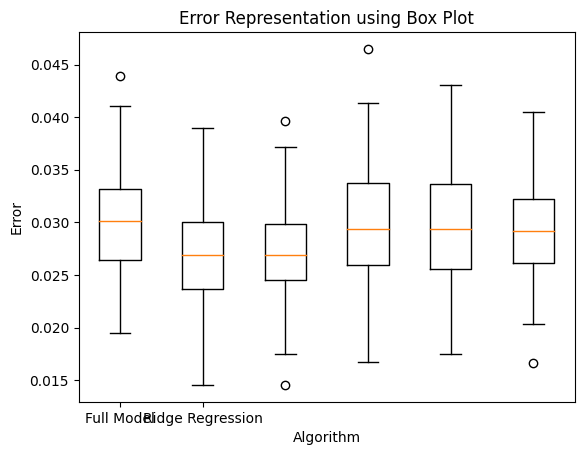

In [30]:
# plot the errors
plot_data = [full_mse_list,ridge_mse_list, lasso_min_list,lasso_1se_list, refit_mse_list, pcr_mse_list ]
methods = ['Full Model', 'Ridge Regression']
plt.boxplot(plot_data)
plt.title('Error Representation using Box Plot')
plt.xlabel('Algorithm')
plt.ylabel('Error')
plt.xticks(range(1, len(methods) + 1), methods)
plt.show()

In [8]:
full = lm().fit(X_train, Y_train)
mean_squared_error(Y_test, full.predict(X_test))

0.021598535596213147

**Part I: Implement Lasso**

**Load Data**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as lm
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [3]:

url = "https://raw.githubusercontent.com/liangfgithub/liangfgithub.github.io/master/Data/Coding2_Data0.csv"
myData = pd.read_csv(url)
var_names = myData.columns
y = myData[['Y']].to_numpy()
X = myData.drop(['Y'], axis = 1).to_numpy()

In [9]:
X.shape, len(y)

((506, 13), 506)

TypeError: 'axis' is an invalid keyword argument for print()

Implementation of minimizer

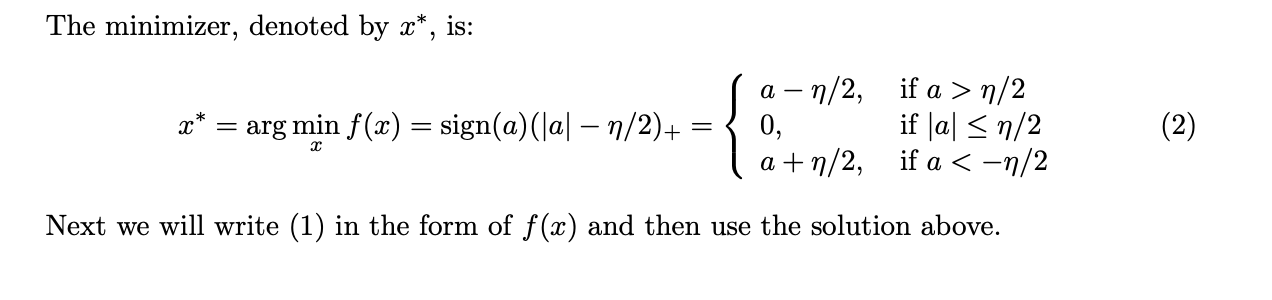

In [10]:
def one_var_lasso(v, z, lam):


  ##############################
  # YOUR CODE
  ##############################

  n = z.shape[0]

  # Calculate r^T z (dot product)
  vtz = np.dot(v.T, z)

  # Calculate ||z||^2 (squared norm)
  z_norm_squared = np.dot(z.T, z)

  # calculate v^T z / ||z||^2
  a = vtz / z_norm_squared
  eta = 2*n*lam/z_norm_squared


  if a > eta/2:
    return a - eta/2
  elif a < -eta/2:
    return a + eta/2
  else:
    return 0


In [11]:
def standardize(X):
    """Standardize the input matrix X and return the standardized matrix,
    the mean, and the standard deviation of each column."""
    means = np.mean(X, axis=0)
    stds = np.std(X, axis=0)
    standardized_X = (X - means) / stds
    return standardized_X, means, stds

In [12]:
def MyLasso(X, y, lam_seq, maxit=100):

    # Input
    # X: n-by-p design matrix without the intercept
    # y: n-by-1 response vector
    # lam.seq: sequence of lambda values (arranged from large to small)
    # maxit: number of updates for each lambda

    # Output
    # B: a (p+1)-by-len(lam.seq) coefficient matrix
    #    with the first row being the intercept sequence

    n, p = X.shape
    nlam = len(lam_seq)
    B = np.zeros((p+1, nlam))  # p+1 because first row is intercept

    ##############################
    # Step 1: Standardize X
    ##############################
    newX, means, stds = standardize(X)

    # Initialize coefficients and residuals
    b = np.zeros(p)
    #r = y - np.mean(y)  # Center the response vector initially
    r = y

    # Triple nested loop: over lambda, iterations, and features
    for m in range(nlam):
        for step in range(maxit):
            for j in range(p):
                X_j = newX[:, j].reshape(-1, 1)  # Select the j-th column of newX
                r = r + X_j * b[j]  # Restore residual before updating b_j
                b[j] = one_var_lasso(r, X_j, lam_seq[m])  # Update b_j using Lasso formula
                r = r - X_j * b[j]  # Update residual after changing b_j
        B[1:, m] = b  # Store coefficients for the current lambda

    ##############################
    # Step 2: Scale back coefficients
    ##############################
    B[1:, :] = B[1:, :] / stds.reshape(-1, 1)  # Scale back coefficients by std of X

    ##############################
    # Step 3: Compute intercepts
    ##############################
    B[0, :] = np.mean(y) - np.dot(means, B[1:, :])  # Update intercepts in B[0,]

    return B

In [13]:
log_lam_seq = np.linspace(-1, -8, num = 80)
lam_seq = np.exp(log_lam_seq)
myout = MyLasso(X, y, lam_seq, maxit = 100)

<ipython-input-12-a5991059896c>:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  b[j] = one_var_lasso(r, X_j, lam_seq[m])  # Update b_j using Lasso formula


(-8.35, -0.6499999999999999, -0.30999458351285203, 0.49974219884805027)

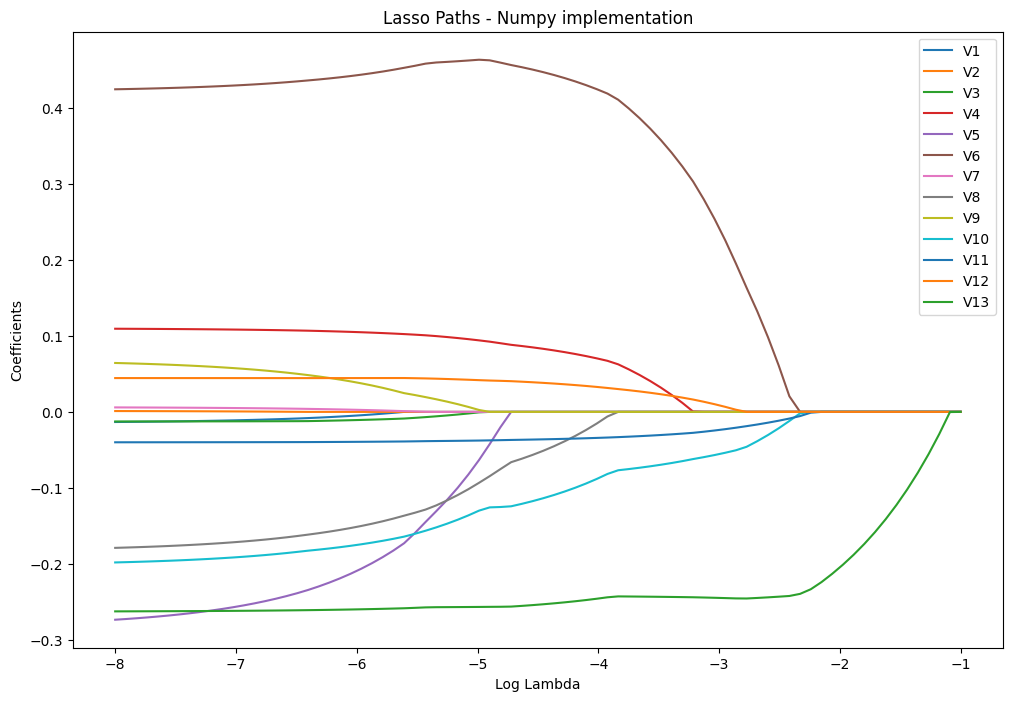

In [14]:
p, _ = myout.shape
plt.figure(figsize = (12,8))

for i in range(p-1):
    plt.plot(log_lam_seq, myout[i+1, :], label = var_names[i])

plt.xlabel('Log Lambda')
plt.ylabel('Coefficients')
plt.title('Lasso Paths - Numpy implementation')
plt.legend()
plt.axis('tight')

In [15]:
url = "https://raw.githubusercontent.com/liangfgithub/liangfgithub.github.io/master/Data/Coding2_lasso_coefs.csv"
lasso_coef = pd.read_csv(url).to_numpy()
lasso_coef.shape

(14, 80)

In [16]:
abs(myout - lasso_coef).max()

0.004645317415915784

In [17]:
# Example vectors (n x 1)
v = np.array([[1], [2], [3]])
z = np.array([[4], [5], [6]])
print(one_var_lasso(v, z, 1))


[[0.37662338]]


In [18]:
v = np.array([1, 2, 3])
print(v.shape)

z = np.array([[1], [2], [3]])
print(z.shape)

(3,)
(3, 1)
